In [1]:
# General
import pandas as pd
import numpy as np
import os
import glob

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# Descriptive statistics
from scipy.stats import ttest_ind, chi2_contingency

# Plotting
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
## Linear regression
from sklearn.linear_model import LinearRegression
## SVR
from sklearn.svm import LinearSVR, SVR
## Neural networks
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
## LGBM
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback

In [2]:
# Get rid of annoying LGBM messages
import warnings
warnings.filterwarnings("ignore", message="categorical_column in param dict is overridden.")
warnings.filterwarnings("ignore", message='Overriding the parameters from Reference Dataset.')
warnings.filterwarnings("ignore", message='The reported value is ignored because this*')
warnings.filterwarnings("ignore", message='Found `n_estimators` in params. Will use it*')
warnings.filterwarnings("ignore", message='The distribution is specified by*')

# Hide optuna logging too
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Pre-processing

In [3]:
# Get files to read in
gcse_files = glob.glob("../fake_data/synthetic_*_gcse_20[1-2][0, 8-9].csv")
npd_files = glob.glob("../fake_data/synthetic_npd_ks4_student_20[1-2][0, 8-9].csv")

## Exam Data

In [4]:
def process_grades(data = pd.DataFrame, grade_col = str):
    
    # Drop rows with missing grades
    data = data.dropna(subset = grade_col)
    # Convert U grade to 0
    data.loc[data[grade_col] == "U", grade_col] = "0"
    # Convert grades to numeric from string format
    data = data[data[grade_col].isin([str(x) for x in (range(0, 10))])]
    data[grade_col] = data[grade_col].astype(float)
    return data

In [5]:
def process_gcse_data(df = pd.DataFrame):
    
    """
    Takes raw GCSE exam data (2017-2020 files), filters it
    appropriately and processes it. 
    Returns a DataFrame with a reduced number of columns.
    Full steps taken can be seen in code commenting or in
    Methodology section of capstone.
    --------------------------------------------------
    df = DataFrame of raw GCSE data
    """
    
    # Copy to prevent in-place changes
    data = df.copy()
    
    # Make cols lowercase
    data.columns = [x.lower() for x in data.columns]
    
    # Reformat examseries to year col
    data["year"] = data.examseries.apply(lambda x: x.split()[1])
    
    # Remove candidates who were not 16 on 31st August
    data = data.query("yearendage == 16")
    # Remove private candidates
    data = data.query("privatecandidate == False")
    # Commented out below since all True in synthetic data
    # Remove partial absentees
#     data = data.query("partialabsence == False")
    # Remove candidates without prior attainment or that weren't matched in NPD
    data = data.dropna(subset = ["normalisedks2score", "npdmatchround"])
    
    # Remove candidates with 0 prior attainment (errors in data)
    data = data[data.normalisedks2score > 0]
    
    # Remove non-reformed GCSEs
    data = data[data.reformphase.isin(['Ofqual-regulated Phase 1 reformed GCSE FC',
                                       'Ofqual-regulated Phase 2 reformed GCSE FC'])]
    # Recode tier into foundation or not foundation
    data.loc[data.tier != "F", "tier"] = "Not F"
    
    # Process grade column inplace
    data = process_grades(data, grade_col = "grade")
    
    # Standardise the KS2 prior attainment to between 0 and 1
    scaler = MinMaxScaler()
    data.normalisedks2score = scaler.fit_transform(data[['normalisedks2score']])
    
    # Get candidates who took at least 8 GCSEs
    grouped = data.groupby("uidp").count()
    at_least_8 = set(grouped[grouped.examseries >= 8].index.to_list())
    # Get candidates who took English and Maths
    eng_math = set(data[data.jcqtitle.isin(["Mathematics", "English language"])].uidp)
    # Get candidates who took English and Maths and >= 8 GCSEs
    filtered_ids = at_least_8 & eng_math
    # Beware that since this is simulated data, it's wrong
    filtered = data[data.uidp.isin(filtered_ids)]
    
    # Select cols needed for modelling and dropnas
    gcse_cols = ["uidp", "year", "jcqtitle", "tier", "centretypedesc",
                 "normalisedks2score", "grade", "centreassessmentgrade"]
    filtered = filtered[gcse_cols]

    return filtered

In [6]:
# Load and process all the GCSE exam data
gcse_data = pd.DataFrame()
# Iterate through files
for file in gcse_files:
    # Perform filtering/pre-processing
    year_df = process_gcse_data(pd.read_csv(file))
    # Process the CAG column too
    if "2020" in file:
        year_df = process_grades(year_df, "centreassessmentgrade")
    # Create dummy value for other years
    else:
        year_df.centreassessmentgrade = np.NaN
        
    # Merge with other years
    gcse_data = pd.concat([gcse_data, year_df])
    # Delete var to save memory
    del year_df
# Reset index
gcse_data = gcse_data.reset_index(drop = True)

In [7]:
# # Take a smaller sample of the GCSE data, overwrite the orignal gcse_data object too
# gcse_data, unneeded_gcse_data = train_test_split(gcse_data, 
#                                                   train_size = 0.1, 
#                                                   stratify = gcse_data.year,
#                                                   random_state = 42, shuffle = True)
# del unneeded_gcse_data

## NPD Data

In [8]:
def process_npd(data = pd.DataFrame):
    
    """
    Takes raw NPD data (2017-2020 files), filters it
    appropriately and processes it. 
    Returns a DataFrame with a reduced number of columns.
    Full steps taken can be seen in code commenting or in
    Methodology section of capstone.
    --------------------------------------------------
    df = DataFrame of raw NPD data
    """    
    
    # Copy to prevent inplace changes
    df = data.copy()
    # Make cols lowercase
    df.columns = [x.lower() for x in df.columns]
    # Select the columns that are common across files
    npd_cols = ["uidp", "ks4_ealgrp_ptq_ee", "ks4_gender"]
    # Get the bases for the columns that change in suffix in each file
    col_bases = ["ethnicgroupmajor", "fsmeligible", "senprovisionmajor"]
    # Get the suffix part that changes
    year_ending = int(file[-6:-4])
    # Dynamically select those cols with changing suffixes
    npd_cols.extend([col_base + f"_spr{year_ending}" for col_base in col_bases])
    # Also add in most recent IDACI score
    npd_cols.append(sorted([x for x in df.columns if "idaciscore" in x])[-1])
    
    # Select the needed columns
    df = df[npd_cols]
    # Add in year col
    df["year"] = f"20{year_ending}"
    # Rename columns
    clean_cols = ["uidp", "eal", "gender", "ethnicity",
              "fsm", "sen", "idaci", "year"]
    df.columns = clean_cols
    
    return df

In [9]:
# Legacy code for checking cols are consistent
# col_dict = dict()
# for file in npd_files:
#     col_dict[file[-8:-4]] = pd.read_csv(file).columns
# set(col_dict["2020"]) & set(col_dict["2019"]) & set(col_dict["2018"])
# set(col_dict["2020"]) - set(col_dict["2019"])

In [10]:
# Create df to store each year's data in
npd_data = pd.DataFrame()

# Iterate through files
for file in npd_files:
    # Load data
    npd_df = pd.read_csv(file)
    # Process the NPD data
    npd_df = process_npd(npd_df)
    # Combine into dataframe
    npd_data = pd.concat([npd_data, npd_df])
    
    # Delete var to save memory
    del npd_df

# Joining

In [11]:
def recode_cols(data = pd.DataFrame):
    """
    Takes processed merged GCSE exam and NPD data (2017-2020 files),
    filters it appropriately and processes it. 
    It recodes several columns into fewer numbers of categories
    to make modelling easier.
    Returns a DataFrame with a reduced number of columns.
    Full steps taken can be seen in code commenting or in
    Methodology section of capstone.
    --------------------------------------------------
    df = DataFrame of merged NPD/GCSE data
    """
    
    # Copy to prevent inplace changes
    df = data.copy()
    # Filter EAL to remove NAs or unclassifieds
    df = df[df.eal.isin([1,2])]
    # Filter ethnicity to remove unclassifieds/NaNs
    df = df[df.ethnicity.isin(["AOEG", "ASIA", "BLAC", "CHIN",
                          "MIXD", "WHIT"])]
    # Filter and recode SEN to remove unclassifieds and make SEN/not SEN
    df = df[df.sen.isin(["1_NON", "2_SNS", "3_SS"])]
    df.loc[df.sen != "1_NON", "sen"] = "SEN"
    df.loc[df.sen == "1_NON", "sen"] = "No SEN"
    
    # Drop remaining NaNs from FSM and IDACI cols
    df = df.dropna(subset = ["fsm", "idaci"])
    
    return df

In [12]:
# Inner join exam data with NPD data
merged = npd_data.merge(gcse_data, on = ["uidp", "year"],
                       how = "inner")

# Recode columns and filter further
df = recode_cols(merged)

# Recode columns and filter further
df = recode_cols(merged)

# Get list of most common subjects to plot with later
most_common_subjects = df.groupby("jcqtitle").count()\
.sort_values("eal", ascending = False)\
.head(10)\
.index\
.to_list()

# Drop now unnecesary UIDP and year cols
df = df.drop(columns = ["year", "uidp"])

# Convert categorical cols to numerics
categorical_cols = ["eal", "gender", "ethnicity", "fsm",
               "sen", "jcqtitle", "tier", "centretypedesc"]

# Encode categorical columns as numerics
# Create mapping to inverse transform with later
mapping = {}
# Iterate through categorical columns
for col in categorical_cols:
    # Instantiate encoder
    encoder = OrdinalEncoder()
    # Store encoding in mapping dict
    mapping[col] = encoder.fit(df[col].values.reshape(-1, 1))
    # Convert column to numerics
    df[col] = encoder.transform(df[col].values.reshape(-1, 1))

In [13]:
# Split into treatment and control
treatment = df[~df.centreassessmentgrade.isna()].copy()
control = df[df.centreassessmentgrade.isna()].copy()

# Split into labels and features
X = np.array(control.iloc[:, :10], dtype = "float32")
y = np.array(control.grade, dtype = "float32")

# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   shuffle = True,
                                                   random_state = 42)

# Descriptive Statistics

## Continuous Variables

In [14]:
# Calculate summary stats of continuous variables
continuous_cols = ['idaci', 'normalisedks2score', 'grade', 'centreassessmentgrade']
control_continuous = control[continuous_cols].apply([np.mean, np.std]).T
treatment_continuous = treatment[continuous_cols].apply([np.mean, np.std]).T

In [20]:
import statsmodels.stats.api as sms

In [21]:
# Save summary stats
summary_cont = pd.merge(control_continuous,
                        treatment_continuous,
                        how = "inner",
                        left_index = True,
                        right_index = True,
                        suffixes = ["_control", "_treatment"])

# Create cols to store results in
summary_cont["p_val"] = np.NaN
summary_cont["conf_lower"] = np.NaN
summary_cont["conf_upper"] = np.NaN

# Run t-tests and conf intervals of mean differences
for col in continuous_cols:
    # Run t-test over each continuous col
    t_test = ttest_ind(treatment[col], control[col])
    
    # Calculate confidence intervals for difference between means
    cm = sms.CompareMeans(sms.DescrStatsW(treatment[col]),
                      sms.DescrStatsW(control[col]))
    lower, upper = cm.tconfint_diff(alpha = 0.05, usevar='unequal')
    
    # Store p-value
    summary_cont.loc[col, "p_val"] = t_test.pvalue
    # Store confidence intervals
    summary_cont.loc[col, "conf_lower"] = lower
    summary_cont.loc[col, "conf_upper"] = upper

# Export results
summary_cont.to_csv("descriptive-continuous.csv")

In [ ]:
summary_cont

In [19]:
import statsmodels.stats.api as sms
summary_cont["conf_lower"] = np.NaN
summary_cont["conf_upper"] = np.NaN
# Calculate confidence intervals for difference between means
cm = sms.CompareMeans(sms.DescrStatsW(treatment[col]),
                  sms.DescrStatsW(control[col]))
lower, upper = cm.tconfint_diff(alpha = 0.05, usevar='unequal')

## Categorical Variables

In [22]:
# Reconvert categorical cols back into original label form
for col in categorical_cols:
    # Inverse transform columns
    control[col] = mapping[col].inverse_transform(control[col].values.reshape(-1, 1))
    treatment[col] = mapping[col].inverse_transform(treatment[col].values.reshape(-1, 1))

In [23]:
# Calculate proportions in each group
summary_cat = pd.DataFrame()

for col in categorical_cols:
    # Get frequencies and proportions for categories in group
    # For control
    control_count = control.groupby(col)["eal"].count()
    control_prop =  control_count / control.shape[0]
    control_sum = pd.DataFrame(data = {"control_count":control_count,
                                       "control_prop": control_prop,
                                       "col": col})
    # For treatment
    treatment_count = treatment.groupby(col)["eal"].count()
    treatment_prop = treatment_count / treatment.shape[0]
    treatment_sum = pd.DataFrame(data = {"treatment_count":treatment_count,
                                         "treatment_prop": treatment_prop,
                                         "col": col})
    # Combine into one df
    comparison = pd.concat([control_sum,
                            treatment_sum[["treatment_count", "treatment_prop"]]], axis = 1).fillna(0)
    # Run chi-square test
    chi2, p, dof, exp = chi2_contingency(comparison[["control_count", "treatment_count"]])
    # Add p-values to df
    comparison["p_val"] = p
    
    # Merge with other results
    summary_cat = pd.concat([summary_cat, comparison])

# Rename index
summary_cat.index.name = "category"
summary_cat = summary_cat.reset_index()
# Export results
summary_cat.to_csv("descriptive-categoricals.csv", index = False)

In [24]:
summary_cat.head()

,category,control_count,control_prop,col,treatment_count,treatment_prop,p_val
0,1.0,104.0,0.800000,eal,95.0,0.669014,0.021548
1,2.0,26.0,0.200000,eal,47.0,0.330986,0.021548
2,F,49.0,0.376923,gender,82.0,0.577465,0.001448
3,M,81.0,0.623077,gender,60.0,0.422535,0.001448
4,ASIA,16.0,0.123077,ethnicity,8.0,0.056338,0.026099


In [25]:
# Plot most common subject mean grades, treatment vs control
subject_treat = treatment.groupby("jcqtitle")[["grade"]].mean()\
.loc[most_common_subjects].reset_index().round(2)
subject_control = control.groupby("jcqtitle")[["grade"]].mean()\
.loc[most_common_subjects].reset_index().round(2)

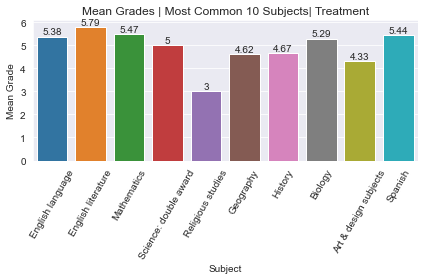

In [26]:
# Plot treatment
fig = sns.barplot(x = "jcqtitle", y = "grade", data = subject_treat)
fig.tick_params(axis='x', rotation=60)
fig.set(xlabel = "Subject", ylabel = "Mean Grade",
        title = "Mean Grades | Most Common 10 Subjects| Treatment")
fig.bar_label(fig.containers[0]);

plt.tight_layout()
plt.savefig("treatment_subj_grades.png")

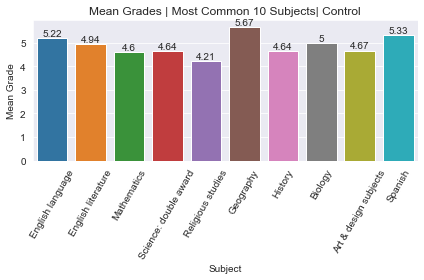

In [27]:
# Plot control
fig = sns.barplot(x = "jcqtitle", y = "grade", data = subject_control)
fig.tick_params(axis='x', rotation=60)
fig.set(xlabel = "Subject", ylabel = "Mean Grade",
        title = "Mean Grades | Most Common 10 Subjects| Control")
fig.bar_label(fig.containers[0]);

plt.tight_layout()
plt.savefig("control_subj_grades.png")

# Modelling

In [28]:
# Create dataframe to store model results in
all_results = pd.DataFrame()

In [29]:
def evaluate_model(X_train, X_test,
                  y_train, y_test,
                  model, model_name):
    
    """
    Function to evaluate a model in terms of
    train and test RMSE.
    Returns a dataframe of model name and RMSEs.
    --------------------------------------------------
    X_train = np.array of X data, used to generate train RMSE
    X_test = np.array of X data, used to generate test RMSE
    y_train = np.array of y data, used to generate train RMSE
    y_test = np.array of y data, used to generate test RMSE
    model = fitted model instance to use with model.predict
    model_name = str, name to save the model under
    """
    # Generate predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    # Evaluate model
    train_rmse = mean_squared_error(y_train, train_preds, squared = False)
    test_rmse = mean_squared_error(y_test, test_preds, squared = False)

    # Store results
    results = pd.DataFrame({"model": model_name,
                            "train_rmse": train_rmse,
                            "test_rmse": test_rmse,
                 }, index = [0])
    
    return results

## Linear Model

In [30]:
# Create linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# Evaluate model, getting test and train RMSE
results = evaluate_model(X_train, X_test,
                         y_train, y_test,
                         linear_model, "ols_linear")
# Store results
all_results = pd.concat([all_results, results])

## Neural Network

The 32-32 network seemed to work quite well. Could also try it with batch normalisation, same again with 64-64 networks

In [31]:
def build_mlp(X_data,
              layer_1_units = 64,
              layer_2_units = 64,
              batch_normalization = False,
              loss = "mse",
              optimizer = "adam",
              metrics = ["mse"]):
    """
    Function to create artificial neural network. Dense layer
    units can be specified, as can the use of batch normalization
    in between the dense layers (this provides mild regularisation)
    and may speed up training.
    Returns a compiled Keras model.
    --------------------------------------------------
    X_data = np.array of X data, used to give input shape to model
    layer_1_units = int, number of neurons in 1st hidden layer
    layer_2_units = int, number of neurons in 2nd hidden layer
    batch_normalization = bool, batch normalize between hidden layers 
    if true
    loss = str, name of loss function to use
    optimizer = str or keras.Optimzer object, optimizer to use
    metrics = list of strings, evaluation metrics to use
    """
    # Build model
    model = Sequential(name = "MLP")
    # 1st Dense layer
    model.add(Dense(units = layer_1_units, activation = "relu", input_shape = (X_data.shape[1], ),
                   kernel_initializer = "he_normal"))
    
    # Add batch normalization if desired
    if batch_normalization:
        model.add(BatchNormalization())
    
    # 2nd Dense layer
    model.add(Dense(units = layer_2_units, activation = "relu",
                   kernel_initializer = "he_normal"))
    # Output layer
    model.add(Dense(units = 1, activation = "linear",
                   kernel_initializer = "he_normal"))
    # Compile model
    model.compile(**compile_hp)
    
    return model

In [32]:
# Hyperparams used during modelling
# Compilation hyperparams
compile_hp = dict()
compile_hp["loss"] = "mse"
compile_hp["optimizer"] = optimizers.Adam(learning_rate = 0.001)
compile_hp["metrics"] = ["mse"]

# Fitting hyperparams
fit_hp = dict()
fit_hp["batch_size"] = 32
fit_hp["epochs"] = 200
fit_hp["validation_split"] = 0.2
# Create callback to select the best model
fit_hp["callbacks"] = EarlyStopping(monitor = "val_loss",
                                         mode = "min",
                                         restore_best_weights = True,
                                         patience = 25)

# Eliminate verbose to have a neater notebook 
fit_hp["verbose"] = 2

### NN 1

In [33]:
# Select number of hidden units
layer_1_units = 32
layer_2_units = 32
# Select whether to batch normalize
batch_normalization = True

# Build and compile model
mlp = build_mlp(X_train,
                  layer_1_units = layer_1_units,
                  layer_2_units = layer_2_units,
                  batch_normalization = batch_normalization,
                  **compile_hp)
# Fit model
history = mlp.fit(X_train, y_train, **fit_hp)

# Get string to save model details with
save_name  = f"neural_network-{layer_1_units}_{layer_2_units}"
if batch_normalization:
    save_name = save_name + "_bn"

# Evaluate model, getting test and train RMSE
results = evaluate_model(X_train, X_test,
                         y_train, y_test,
                         mlp, save_name)
# Store results
all_results = pd.concat([all_results, results])

Metal device set to: Apple M1


2022-08-05 15:39:25.539759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 15:39:25.540481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-05 15:39:25.734618: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-08-05 15:39:25.966374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 - 1s - loss: 25.4179 - mse: 25.4179 - val_loss: 17.7134 - val_mse: 17.7134 - 556ms/epoch - 185ms/step
Epoch 2/200
3/3 - 0s - loss: 23.9126 - mse: 23.9126 - val_loss: 16.5251 - val_mse: 16.5251 - 33ms/epoch - 11ms/step
Epoch 3/200
3/3 - 0s - loss: 22.9397 - mse: 22.9397 - val_loss: 15.6008 - val_mse: 15.6008 - 32ms/epoch - 11ms/step
Epoch 4/200
3/3 - 0s - loss: 21.6539 - mse: 21.6539 - val_loss: 14.7721 - val_mse: 14.7721 - 30ms/epoch - 10ms/step
Epoch 5/200
3/3 - 0s - loss: 20.9097 - mse: 20.9097 - val_loss: 14.0620 - val_mse: 14.0620 - 30ms/epoch - 10ms/step
Epoch 6/200


2022-08-05 15:39:26.279161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 - 0s - loss: 19.3122 - mse: 19.3122 - val_loss: 13.4832 - val_mse: 13.4832 - 31ms/epoch - 10ms/step
Epoch 7/200
3/3 - 0s - loss: 18.7162 - mse: 18.7162 - val_loss: 12.9877 - val_mse: 12.9877 - 34ms/epoch - 11ms/step
Epoch 8/200
3/3 - 0s - loss: 17.5068 - mse: 17.5068 - val_loss: 12.6125 - val_mse: 12.6125 - 30ms/epoch - 10ms/step
Epoch 9/200
3/3 - 0s - loss: 16.4094 - mse: 16.4094 - val_loss: 12.2552 - val_mse: 12.2552 - 30ms/epoch - 10ms/step
Epoch 10/200
3/3 - 0s - loss: 15.8161 - mse: 15.8161 - val_loss: 11.9885 - val_mse: 11.9885 - 30ms/epoch - 10ms/step
Epoch 11/200
3/3 - 0s - loss: 14.5212 - mse: 14.5212 - val_loss: 11.7571 - val_mse: 11.7571 - 32ms/epoch - 11ms/step
Epoch 12/200
3/3 - 0s - loss: 14.1502 - mse: 14.1502 - val_loss: 11.5742 - val_mse: 11.5742 - 42ms/epoch - 14ms/step
Epoch 13/200
3/3 - 0s - loss: 13.4697 - mse: 13.4697 - val_loss: 11.3977 - val_mse: 11.3977 - 34ms/epoch - 11ms/step
Epoch 14/200
3/3 - 0s - loss: 12.7181 - mse: 12.7181 - val_loss: 11.2353 - val_m

2022-08-05 15:39:31.685529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## LGBM

In [34]:
# Params to compile LGBM model with
fixed_params = {
        'objective': 'regression',
        'metric': "rmse",  
        'verbosity': -1,
}

In [35]:
def objective(trial, X, y):
    """
    Wrapper function to work with Optuna trial objects, 
    enabling Hyperband hyperparameter search.
    """   
    # Suggest hyperparams to test using Optuna trial object.
    param = {**fixed_params,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 3000, step = 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.99, step = 0.05),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.99, step = 0.05),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 2000, step=5),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 10),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
    }
    
    # Create cv object
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    # Make empty array to store cv RMSE scores in
    cv_scores = np.empty(5)
    
    # Split into K train and validation sets and iterate through them
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Split into training and validation CV sets
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Convert data to proper LGBM format
        train_data = lgb.Dataset(X_train_cv, label = y_train_cv,
                                 categorical_feature = [0,1,2,3,4,6,7,8])
        val_data = lgb.Dataset(X_test_cv, label = y_test_cv, 
                               categorical_feature = [0,1,2,3,4,6,7,8],
                              reference = train_data)
        
        # Make callbacks to prevent trialling hyperparams that are obviously bad
        callbacks = [
            LightGBMPruningCallback(trial, metric = "rmse"),
                     # Callback to reduce model validation performance messages
                    lgb.log_evaluation(period = 100),
                     # Early stoppping to prevent overfitting training data
                    lgb.early_stopping(100)]

        # Training the model
        model = lgb.train(params = param,  train_set = train_data,
                          valid_sets = val_data,   
                          callbacks = callbacks,
                         )
    
        # Get predictions
        preds = model.predict(X_test_cv)
        # Calculate RMSE
        cv_scores[idx] = mean_squared_error(y_test_cv, preds, squared = False)

    return np.mean(cv_scores)

In [36]:
%%capture my_study
# Above line magic hides lengthy output, but stores into first_round if you want to look

# Create Optuna study to do CV hyperparameter search
study = optuna.create_study(direction = "minimize", # minimizing RMSE
                            study_name = "LGBM Classifier",
                           pruner = optuna.pruners.HyperbandPruner())
func = lambda trial: objective(trial, X = X_train, y = y_train)
study.optimize(func, n_trials = 200)

In [37]:
# Run best model and evaluate
# Convert data to proper LGBM format
train_data = lgb.Dataset(X_train, label = y_train,
                         categorical_feature = [0,1,2,3,4,6,7,8])

# Callback to reduce model messages
callbacks = [lgb.log_evaluation(period = 100)]

# Training the model using the best params identified in study
lgbm = lgb.train(params = {**fixed_params, **study.best_params},
                  train_set = train_data, 
                  callbacks = callbacks,
                 )

# Evaluate model, getting test and train RMSE
results = evaluate_model(X_train, X_test,
                         y_train, y_test,
                         lgbm, "lgbm")
# Store results
all_results = pd.concat([all_results, results])

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=10


/Users/louis/miniforge3/envs/skywalker/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Support Vector Regression

### RBF SVR

In [38]:
# Create model
rbf_svr = SVR()
# Fit
rbf_svr.fit(X_train, y_train)
# Evaluate model, getting test and train RMSE
results = evaluate_model(X_train, X_test,
                         y_train, y_test,
                         rbf_svr, "svm_rbf")
# Store results
all_results = pd.concat([all_results, results])

### LinearSVR

In [39]:
# Create model
epsilon = 0.499
linear_svr = LinearSVR(epsilon = epsilon)
# Fit
linear_svr.fit(X_train, y_train)
# Evaluate model, getting test and train RMSE
results = evaluate_model(X_train, X_test,
                         y_train, y_test,
                         linear_svr, f"svm_linear-{epsilon}")
# Store results
all_results = pd.concat([all_results, results])

/Users/louis/miniforge3/envs/skywalker/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Analysing Results / Using Best Model

## Make Predictions

In [40]:
# Compare model performances
best = all_results.sort_values("test_rmse").head(1)
all_results.sort_values("test_rmse")
all_results.to_csv("model_evaluations.csv", index = False)

In [41]:
# Select best model and it's test RMSE
best_model = rbf_svr
best_rmse = best.test_rmse

In [42]:
# Get treatment in numeric form again
treatment = df[~df.centreassessmentgrade.isna()].copy()

# Split into labels and features
X_treatment = np.array(treatment.iloc[:, :10], dtype = "float32")
y_treatment = np.array(treatment.grade, dtype = "float32")

In [43]:
# Calculate predictions for 2020 year using best model
treatment["predictions"] = best_model.predict(X_treatment)
# Calculate differences from CAG
treatment["cag_diff"] = treatment.centreassessmentgrade - treatment.predictions

In [44]:
# Create quantiles for IDACI and prior attainment
quantile_labels = ["very low", "low", "medium", "high", "very high"]
treatment["idaci_quantile"] = pd.qcut(treatment.idaci, 
                                      q = 5,
                                      labels = quantile_labels)
treatment["attainment_quantile"] = pd.qcut(treatment.normalisedks2score, 
                                      q = 5,
                                      labels = quantile_labels)
# Reconvert categorical cols back into original label form
for col in categorical_cols:
    # Inverse transform columns
    treatment[col] = mapping[col].inverse_transform(treatment[col].values.reshape(-1, 1))
    
# Create neater labels for certain columns
# EAL
eal_mappings = {1.0:"No EAL", 2.0: "EAL"}
treatment.eal = treatment.eal.replace(eal_mappings)
# FSM
fsm_mappings = {0:"No FSM", 1: "FSM"}
treatment.fsm = treatment.fsm.replace(fsm_mappings)

## Analyse Feature Importance

In [45]:
import shap

In [49]:
df.columns[:-2]

Index(['eal', 'gender', 'ethnicity', 'fsm', 'sen', 'idaci', 'jcqtitle', 'tier',
       'centretypedesc', 'normalisedks2score'],
      dtype='object')

In [47]:
df[:-2]

,eal,gender,ethnicity,fsm,sen,idaci,jcqtitle,tier,centretypedesc,normalisedks2score,grade,centreassessmentgrade
0,1.0,0.0,3.0,0.0,1.0,0.12,3.0,1.0,0.0,0.543113,4.0,9.0
1,1.0,0.0,3.0,0.0,1.0,0.12,7.0,1.0,0.0,0.290575,7.0,8.0
2,1.0,0.0,3.0,0.0,1.0,0.12,7.0,1.0,5.0,0.321432,4.0,7.0
3,1.0,0.0,3.0,0.0,1.0,0.12,13.0,1.0,4.0,0.736166,9.0,5.0
4,1.0,0.0,3.0,0.0,1.0,0.12,7.0,1.0,0.0,0.432596,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.0,0.0,3.0,0.0,0.0,0.14,13.0,1.0,0.0,0.478605,2.0,NaN
393,0.0,0.0,3.0,0.0,0.0,0.14,14.0,1.0,5.0,0.354737,5.0,NaN
394,0.0,0.0,3.0,0.0,0.0,0.14,19.0,1.0,6.0,0.589380,3.0,NaN
395,0.0,0.0,3.0,0.0,0.0,0.14,8.0,1.0,0.0,0.581628,5.0,NaN


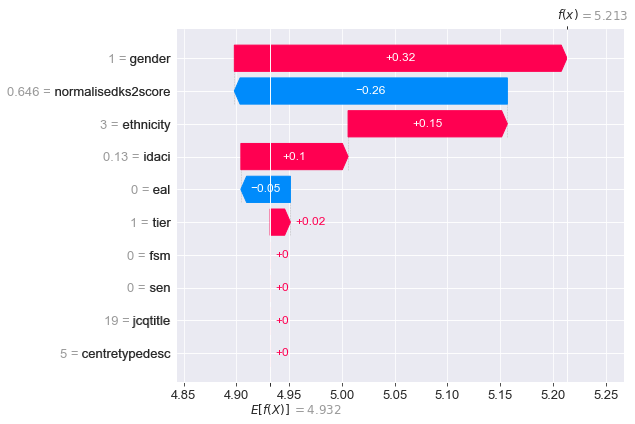

In [199]:
# LGBM shap
# Explain the model's predictions using SHAP
explainer = shap.Explainer(lgbm)
shap_values = explainer(pd.DataFrame(X_train, columns = df.columns[:-2]))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

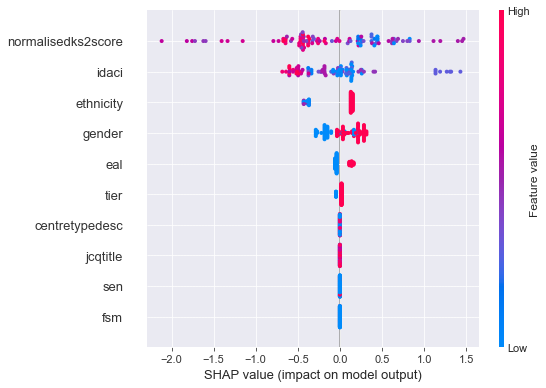

In [191]:
# LGBM shap
shap.summary_plot(shap_values)

Using 104 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/104 [00:00<?, ?it/s]

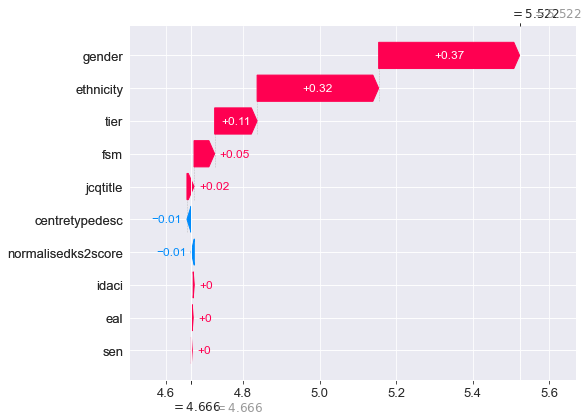

In [195]:
# RBF SVR shap or linear SVR
# Explain the model's predictions using SHAP
explainer = shap.KernelExplainer(linear_svr.predict, X_train)
# Hide annoying messages
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_train)
# visualize the first prediction's explanation
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                       shap_values[0], 
                                       feature_names = df.columns[:-2],
                                       show = True)

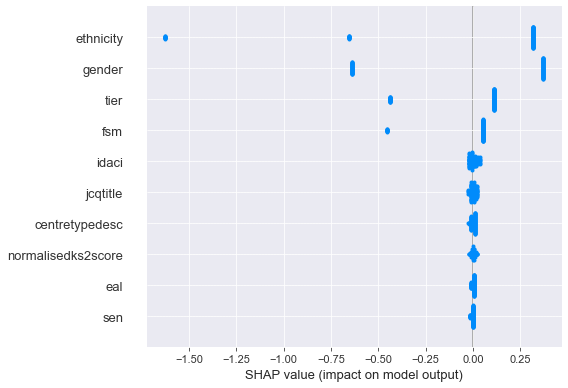

In [197]:
# RBF SVR shap or linear SVR
shap.summary_plot(shap_values, feature_names = df.columns[:-2],
                                       show = True)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-07-30 20:00:41.341845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


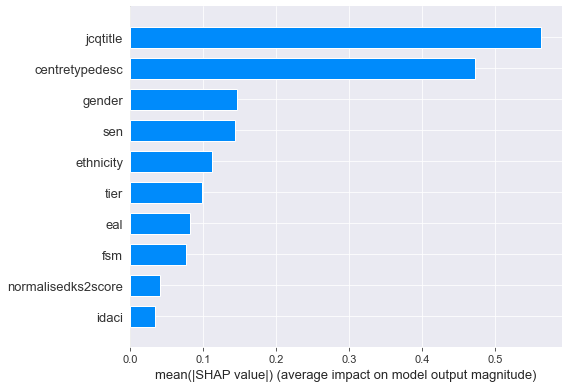

In [154]:
# Deep learning SHAP
explainer = shap.DeepExplainer(mlp, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], plot_type = 'bar', 
                  feature_names = df.columns[:-2])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-07-30 20:28:39.803808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


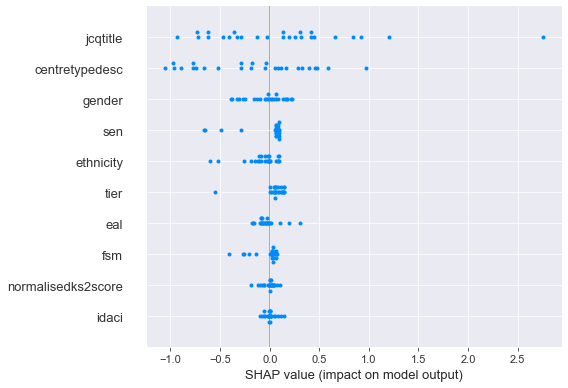

In [198]:
explainer = shap.DeepExplainer(mlp, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], feature_names = df.columns[:-2])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-07-30 20:12:32.404650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


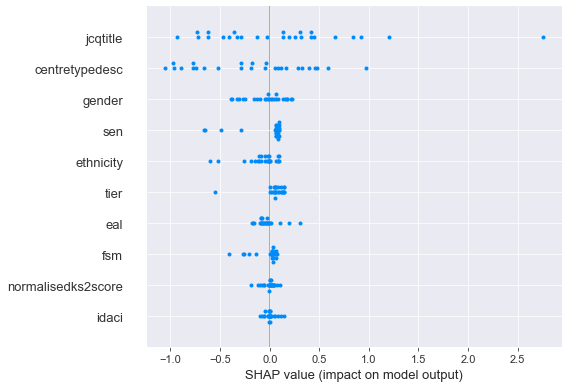

In [169]:
# Deep learning SHAP
explainer = shap.DeepExplainer(mlp, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0],
                  feature_names = df.columns[:-2])

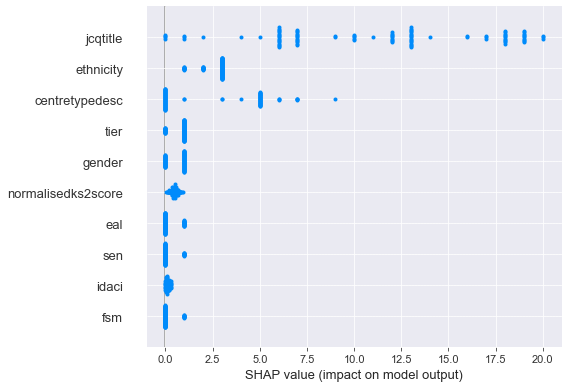

In [170]:
shap.summary_plot(X_train,
                  feature_names = df.columns[:-2])

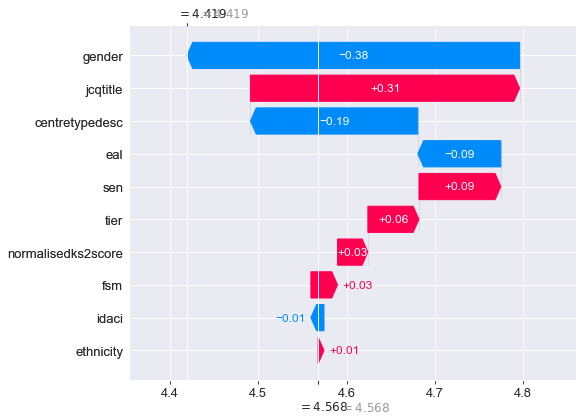

In [155]:
# deep learning shap
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(),
                                       shap_values[0][0],
                                       feature_names = df.columns[:-2])

In [153]:
# Explain the model's predictions using SHAP
explainer = shap.KernelExplainer(mlp.predict, X_train)
# Hide annoying messages
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_train, nsamples = 100)
# visualize the first prediction's explanation
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], 
                                       shap_values[0], 
                                       feature_names = df.columns[:-2],
                                       show = True)

Using 104 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/104 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Analyse Predictions

In [40]:
# Get list of factors to aggregate by, including intersectional factors
groupers = [["ethnicity", "idaci_quantile"],
            ["ethnicity", "attainment_quantile"],
            ["ethnicity", "idaci_quantile", "attainment_quantile"],
            ["ethnicity", "idaci_quantile", "attainment_quantile", "eal"],
            ["ethnicity", "idaci_quantile", "attainment_quantile", "fsm"],
            ["ethnicity", "idaci_quantile", "attainment_quantile", "sen"],
            ["ethnicity", "idaci_quantile", "attainment_quantile", "tier"],
            ["idaci_quantile", "attainment_quantile"],
            ["idaci_quantile", "fsm"],
            ["idaci_quantile", "fsm", "attainment_quantile"],
            ["sen", "ethnicity"],
            ["sen", "idaci_quantile"],
            ["sen", "attainment_quantile"],
            ["eal", "ethnicity"],
            ["eal", "idaci_quantile"],
            ["eal", "attainment_quantile"],
            'eal', 'gender', 'ethnicity',
            'fsm', 'sen', 'jcqtitle', 'tier',
            'centretypedesc','idaci_quantile',
            'attainment_quantile']

In [82]:
# Create df to store each group's results in
all_groups = pd.DataFrame()
for grouper in groupers:
    group_df = treatment.groupby(grouper)[["cag_diff", "centreassessmentgrade"]].mean().reset_index()
    # Store values for factor and factor values
    group_df["factor"] = "X".join(grouper) if isinstance(grouper, list) else grouper
    group_df["factor_value"] = group_df.iloc[:, 0].astype(str)
    
    # Also concat factor value when grouper is more than 1 item
    if isinstance(grouper, list):
        for i in range(1, len(grouper)):
            group_df["factor_value"] = group_df["factor_value"] + " X " + group_df.iloc[:, i].astype(str)
    
    # Save results to df
    all_groups = pd.concat([all_groups, group_df[["factor", "factor_value",
                                                  "cag_diff", "centreassessmentgrade"]]])

# Export results
all_groups.sort_values(["factor", "factor_value"]).to_csv("predicted_diffs.csv", index = False)